# RKHS-SHAP on California Housing Dataset

This notebook demonstrates exact RKHS-SHAP versus Kernel SHAP on the California housing dataset using Gaussian Process regression.

## Overview
- **Dataset**: California housing (8 features)
- **Model**: ExactGPModel with RBF kernel
- **Analysis**: Kernel SHAP vs Interventional RKHS-SHAP

In [57]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from rkhs_shap.exact_gp import ExactGPModel
from rkhs_shap.rkhs_shap_exact import RKHSSHAP

plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline

warnings.filterwarnings("ignore")

# large, with comparison (slowest)
SAMPLE_SIZES = [100, 250, 500, 1000, 5000, 10000]
KERNEL_SHAP_MAX_SAMPLES = 500
EXPLAIN_SIZE = None

# large, only rkhs
# SAMPLE_SIZES = [100, 250, 500, 1000, 5000, 10000]
# KERNEL_SHAP_MAX_SAMPLES = 10
# EXPLAIN_SIZE = None

# fast, both
# SAMPLE_SIZES = [100, 250, 500, 1000]
# KERNEL_SHAP_MAX_SAMPLES = 500
# EXPLAIN_SIZE: int | None = 20

# smoke test
# SAMPLE_SIZES = [100, 250]
# EXPLAIN_SIZE = 10
# KERNEL_SHAP_MAX_SAMPLES = 250

VAL_SAMPLE_SIZE = 500
BACKGROUND_SIZE = 100
RANDOM_STATE = 42

print(f"Sample sizes to analyze: {SAMPLE_SIZES}")

Sample sizes to analyze: [100, 250, 500, 1000, 5000, 10000]


## Load and Prepare Dataset

In [58]:
def load_scaled_dataset(n_train: int, n_val: int = VAL_SAMPLE_SIZE):
    """Load and scale California housing dataset."""
    X, y = shap.datasets.california()
    rng = np.random.default_rng(RANDOM_STATE)

    n_indices = n_train + n_val
    both_indices = rng.choice(len(X), size=n_indices, replace=False)
    train_indices = both_indices[:n_train]
    val_indices = both_indices[n_train:]

    X_train = X.iloc[train_indices].values
    y_train = y[train_indices]
    X_val = X.iloc[val_indices].values
    y_val = y[val_indices]

    feature_scaler = MinMaxScaler()
    X_train = feature_scaler.fit_transform(X_train)
    X_val = feature_scaler.transform(X_val)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = target_scaler.transform(y_val.reshape(-1, 1)).flatten()

    print(
        f"y_train mean: {y_train.mean():.4f}, range: [{y_train.min():.4f}, {y_train.max():.4f}]"
    )

    return X_train, y_train, X_val, y_val


X_full, y_full, X_scaled, y_scaled = load_scaled_dataset(20640 - VAL_SAMPLE_SIZE)

feature_names = shap.datasets.california()[0].columns.tolist()

print(f"Full dataset shape: {X_full.shape}")
print(f"Features: {feature_names}")

y_train mean: 0.0000, range: [-1.6632, 2.5450]
Full dataset shape: (20140, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [59]:
from rkhs_shap.utils import calculate_additivity_mae, calculate_correlation, to_tensor


def train_gp_model(X_train: np.ndarray, y_train: np.ndarray, training_iter: int = 50):
    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    model = ExactGPModel(train_x, train_y)
    model.fit(training_iter=training_iter, lr=0.1)
    return model


def run_kernel_shap(model, X_background, X_explain, feature_names):
    """Run Kernel SHAP on the GP model."""
    start_time = time.time()
    explainer = shap.KernelExplainer(
        model=model.predict_mean_numpy,
        data=X_background,
        feature_names=feature_names,
    )
    explanation = explainer(X_explain)
    shap_time = time.time() - start_time

    return explanation, shap_time


def run_rkhs_shap(
    model: ExactGPModel,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_explain: np.ndarray,
) -> tuple[np.ndarray, float]:
    """Run exact RKHS-SHAP (Interventional) on the GP model."""
    start_time = time.time()

    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    noise_var = model.likelihood.noise.detach().cpu().float()

    rkhs_shap = RKHSSHAP(
        X=train_x,
        y=train_y,
        kernel=model.covar_module,
        noise_var=noise_var,
        cme_reg=1e-4,
        mean_function=model.mean_module,
    )

    X_explain_tensor = to_tensor(X_explain)
    shap_values = rkhs_shap.fit(
        X_test=X_explain_tensor,
        method="I",  # Interventional
        sample_method="full",
    )

    shap_time = time.time() - start_time
    explanation = shap.Explanation(
        values=shap_values,
        data=X_explain,
        feature_names=feature_names,
    )
    return explanation, shap_time


def compute_accuracy_metrics(
    kernel_explanation: shap.Explanation | None,
    rkhs_explanation: shap.Explanation,
    model_predictions: np.ndarray,
    baseline: float,
) -> dict[str, float]:
    """Compare RKHS-SHAP and Kernel SHAP accuracy."""
    rkhs_values = rkhs_explanation.values
    if kernel_explanation is None:
        kernel_values = np.zeros_like(rkhs_values)
    else:
        kernel_values = kernel_explanation.values

    kernel_additivity_errors = calculate_additivity_mae(
        kernel_values, to_tensor(model_predictions), baseline
    )
    rkhs_additivity_errors = calculate_additivity_mae(
        rkhs_values, to_tensor(model_predictions), baseline
    )

    correlation = calculate_correlation(kernel_values, rkhs_values)
    mse = np.mean((kernel_values - rkhs_values) ** 2)

    if kernel_explanation is None:
        kernel_additivity_errors = [np.nan] * len(rkhs_values)
        correlation = np.nan
        mse = np.nan

    return {
        "kernel_additivity_mae": np.mean(kernel_additivity_errors),
        "rkhs_additivity_mae": np.mean(rkhs_additivity_errors),
        "methods_correlation": correlation,
        "methods_mse": mse,
    }

In [60]:
all_metrics = []
all_kernel_explanations = []
all_rkhs_explanations = []
all_models = []
all_scalers = []
rng = np.random.default_rng(RANDOM_STATE)

for sample_size in SAMPLE_SIZES:
    print(f"\n{'=' * 70}")
    print(f"Analyzing sample size: {sample_size}")
    print(f"{'=' * 70}")

    X_train, y_train, X_val, y_val = load_scaled_dataset(sample_size)

    print("Training GP model...")
    start_time = time.time()
    model = train_gp_model(X_train, y_train)
    all_models.append(model)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f}s")

    y_pred = model.predict_mean_numpy(X_val)
    r2 = r2_score(y_val, y_pred)
    print(f"Model R² on validation set: {r2:.4f}")
    print(f"Learned mean function: {model.mean_module.constant.item():.4f}")

    if EXPLAIN_SIZE is not None:
        X_explain = X_train[:EXPLAIN_SIZE]  # Explain first EXPLAIN_SIZE points
    else:
        X_explain = X_train  # Explain all points
    print(f"Explaining {X_explain.shape[0]} points")

    if sample_size > KERNEL_SHAP_MAX_SAMPLES:
        # Run Kernel SHAP
        print(
            f"Skipping Kernel SHAP for sample size {sample_size} > {KERNEL_SHAP_MAX_SAMPLES})"
        )
        kernel_explanation = None
        kernel_shap_time = np.nan
    else:
        print("Running Kernel SHAP...")
        background_indices = rng.choice(
            len(X_train), size=BACKGROUND_SIZE, replace=False
        )
        X_background = X_train[background_indices]
        print(f"KernelSHAP background size: {X_background.shape[0]}")
        kernel_explanation, kernel_shap_time = run_kernel_shap(
            model, X_background, X_explain, feature_names
        )
        print(f"Kernel SHAP time: {kernel_shap_time:.2f}s")
    all_kernel_explanations.append(kernel_explanation)

    # Run RKHS-SHAP
    print("Running RKHS-SHAP...")
    rkhs_explanation, rkhs_shap_time = run_rkhs_shap(model, X_train, y_train, X_explain)
    print(f"RKHS-SHAP time: {rkhs_shap_time:.2f}s")
    all_rkhs_explanations.append(rkhs_explanation)

    # Note: Predictions take quite long for large datasets
    pred_explain = model.predict_mean_numpy(X_explain)
    baseline = model.predict_mean_numpy(X_train).mean()
    accuracy_metrics = compute_accuracy_metrics(
        kernel_explanation,
        rkhs_explanation,
        pred_explain,
        baseline,
    )

    print(f"Model prediction baseline: {baseline:.4f}")
    print(f"Methods correlation: {accuracy_metrics['methods_correlation']:.3f}")
    print(f"Kernel additivity MAE: {accuracy_metrics['kernel_additivity_mae']:.4f}")
    print(f"RKHS additivity MAE: {accuracy_metrics['rkhs_additivity_mae']:.4f}")

    # Store metrics
    metrics = {
        "sample_size": sample_size,
        "training_time": training_time,
        "model_r2": r2,
        "kernel_shap_time": kernel_shap_time,
        "rkhs_shap_time": rkhs_shap_time,
        **accuracy_metrics,
    }
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print(f"\n{'=' * 70}")
print("Analysis complete!")
print(f"{'=' * 70}")


Analyzing sample size: 100
y_train mean: -0.0000, range: [-1.3765, 2.5858]
Training GP model...
iter 1/50 - loss: 1.095 {} noise: 0.693
iter 10/50 - loss: 0.866 {} noise: 0.342
iter 20/50 - loss: 0.750 {} noise: 0.156
iter 30/50 - loss: 0.744 {} noise: 0.110
iter 40/50 - loss: 0.733 {} noise: 0.125
iter 50/50 - loss: 0.730 {} noise: 0.143
Training time: 0.08s
Model R² on validation set: 0.6696
Learned mean function: 0.5180
Explaining 100 points
Running Kernel SHAP...
KernelSHAP background size: 100


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 1.71s
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 1020.84it/s]


RKHS-SHAP time: 0.26s
Model prediction baseline: -0.0004
Methods correlation: 1.000
Kernel additivity MAE: 0.0000
RKHS additivity MAE: 0.0000

Analyzing sample size: 250
y_train mean: -0.0000, range: [-1.3842, 2.3035]
Training GP model...
iter 1/50 - loss: 1.080 {} noise: 0.693
iter 10/50 - loss: 0.925 {} noise: 0.347
iter 20/50 - loss: 0.901 {} noise: 0.203
iter 30/50 - loss: 0.890 {} noise: 0.237
iter 40/50 - loss: 0.891 {} noise: 0.273
iter 50/50 - loss: 0.888 {} noise: 0.244
Training time: 0.14s
Model R² on validation set: 0.7109
Learned mean function: 0.3919
Explaining 250 points
Running Kernel SHAP...
KernelSHAP background size: 100


  0%|          | 0/250 [00:00<?, ?it/s]

Kernel SHAP time: 6.39s
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 704.28it/s]


RKHS-SHAP time: 0.37s
Model prediction baseline: 0.0001
Methods correlation: 1.000
Kernel additivity MAE: 0.0401
RKHS additivity MAE: 0.0000

Analyzing sample size: 500
y_train mean: -0.0000, range: [-1.3934, 2.4511]
Training GP model...
iter 1/50 - loss: 1.048 {} noise: 0.693
iter 10/50 - loss: 0.893 {} noise: 0.347
iter 20/50 - loss: 0.850 {} noise: 0.192
iter 30/50 - loss: 0.846 {} noise: 0.186
iter 40/50 - loss: 0.842 {} noise: 0.209
iter 50/50 - loss: 0.841 {} noise: 0.217
Training time: 0.29s
Model R² on validation set: 0.7095
Learned mean function: 0.1583
Explaining 500 points
Running Kernel SHAP...
KernelSHAP background size: 100


  0%|          | 0/500 [00:00<?, ?it/s]

Kernel SHAP time: 26.20s
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 499.29it/s]


RKHS-SHAP time: 0.52s
Model prediction baseline: 0.0001
Methods correlation: 0.999
Kernel additivity MAE: 0.0066
RKHS additivity MAE: 0.0000

Analyzing sample size: 1000
y_train mean: 0.0000, range: [-1.4369, 2.5268]
Training GP model...
iter 1/50 - loss: 1.008 {} noise: 0.693
iter 10/50 - loss: 0.829 {} noise: 0.345
iter 20/50 - loss: 0.775 {} noise: 0.181
iter 30/50 - loss: 0.767 {} noise: 0.156
iter 40/50 - loss: 0.773 {} noise: 0.143
iter 50/50 - loss: 0.793 {} noise: 0.129
Training time: 0.62s
Model R² on validation set: 0.7352
Learned mean function: -0.1267
Explaining 1000 points
Skipping Kernel SHAP for sample size 1000 > 500)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:01<00:00, 204.07it/s]


RKHS-SHAP time: 1.27s
Model prediction baseline: 0.0013
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0066

Analyzing sample size: 5000
y_train mean: -0.0000, range: [-1.6596, 2.5478]
Training GP model...
iter 1/50 - loss: 1.000 {} noise: 0.693
iter 10/50 - loss: 0.817 {} noise: 0.346
iter 20/50 - loss: 0.694 {} noise: 0.181
iter 30/50 - loss: 0.598 {} noise: 0.110
iter 40/50 - loss: 0.592 {} noise: 0.057
iter 50/50 - loss: 0.656 {} noise: 0.030
Training time: 10.38s
Model R² on validation set: 0.7733
Learned mean function: -0.1448
Explaining 5000 points
Skipping Kernel SHAP for sample size 5000 > 500)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:12<00:00, 19.75it/s]


RKHS-SHAP time: 13.14s
Model prediction baseline: -0.0000
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0073

Analyzing sample size: 10000
y_train mean: -0.0000, range: [-1.6631, 2.5495]
Training GP model...
iter 1/50 - loss: 1.004 {} noise: 0.693
iter 10/50 - loss: 0.856 {} noise: 0.349
iter 20/50 - loss: 0.736 {} noise: 0.199
iter 30/50 - loss: 0.627 {} noise: 0.126
iter 40/50 - loss: 0.597 {} noise: 0.072
iter 50/50 - loss: 0.616 {} noise: 0.042
Training time: 55.97s
Model R² on validation set: 0.7895
Learned mean function: -0.1094
Explaining 10000 points
Skipping Kernel SHAP for sample size 10000 > 500)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:59<00:00,  4.28it/s]


RKHS-SHAP time: 61.14s
Model prediction baseline: 0.0014
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.0073

Analysis complete!


## Visualize Results

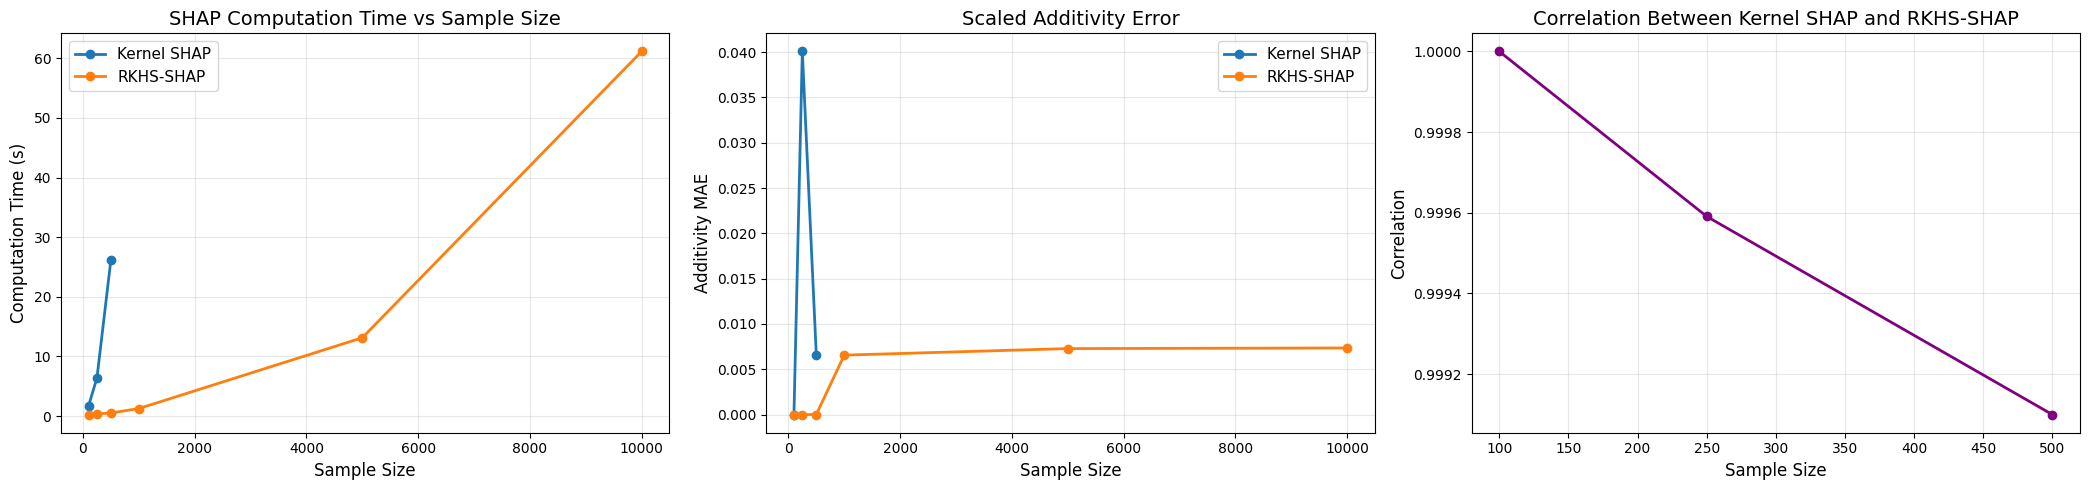


Metrics Summary:
 sample_size  training_time  model_r2  kernel_shap_time  rkhs_shap_time  kernel_additivity_mae  rkhs_additivity_mae  methods_correlation  methods_mse
         100       0.082749  0.669612          1.707322        0.256358               0.000001             0.000002             1.000000 5.092810e-13
         250       0.138577  0.710864          6.385589        0.368972               0.040067             0.000002             0.999591 1.400598e-04
         500       0.287161  0.709537         26.204765        0.520082               0.006605             0.000004             0.999100 9.997078e-05
        1000       0.615853  0.735203               NaN        1.266312                    NaN             0.006558                  NaN          NaN
        5000      10.381936  0.773283               NaN       13.135706                    NaN             0.007282                  NaN          NaN
       10000      55.966782  0.789508               NaN       61.140882           

In [61]:
# Performance comparison plots
kernel_color = "#1f77b4"  # Blue
rkhs_color = "#ff7f0e"  # Orange

fig, axs = plt.subplots(1, 3, figsize=(21, 5))

# Computation time
axs[0].plot(
    metrics_df["sample_size"],
    metrics_df["kernel_shap_time"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[0].plot(
    metrics_df["sample_size"],
    metrics_df["rkhs_shap_time"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[0].set_xlabel("Sample Size", fontsize=12)
axs[0].set_ylabel("Computation Time (s)", fontsize=12)
axs[0].set_title("SHAP Computation Time vs Sample Size", fontsize=14)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3)

# Additivity error
axs[1].plot(
    metrics_df["sample_size"],
    metrics_df["kernel_additivity_mae"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[1].plot(
    metrics_df["sample_size"],
    metrics_df["rkhs_additivity_mae"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[1].set_xlabel("Sample Size", fontsize=12)
axs[1].set_ylabel("Additivity MAE", fontsize=12)
axs[1].set_title("Scaled Additivity Error", fontsize=14)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3)

# Correlation
axs[2].plot(
    metrics_df["sample_size"],
    metrics_df["methods_correlation"],
    marker="o",
    color="purple",
    linewidth=2,
)
axs[2].set_xlabel("Sample Size", fontsize=12)
axs[2].set_ylabel("Correlation", fontsize=12)
axs[2].set_title("Correlation Between Kernel SHAP and RKHS-SHAP", fontsize=14)
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))

## SHAP Value Comparison for Each Sample Size

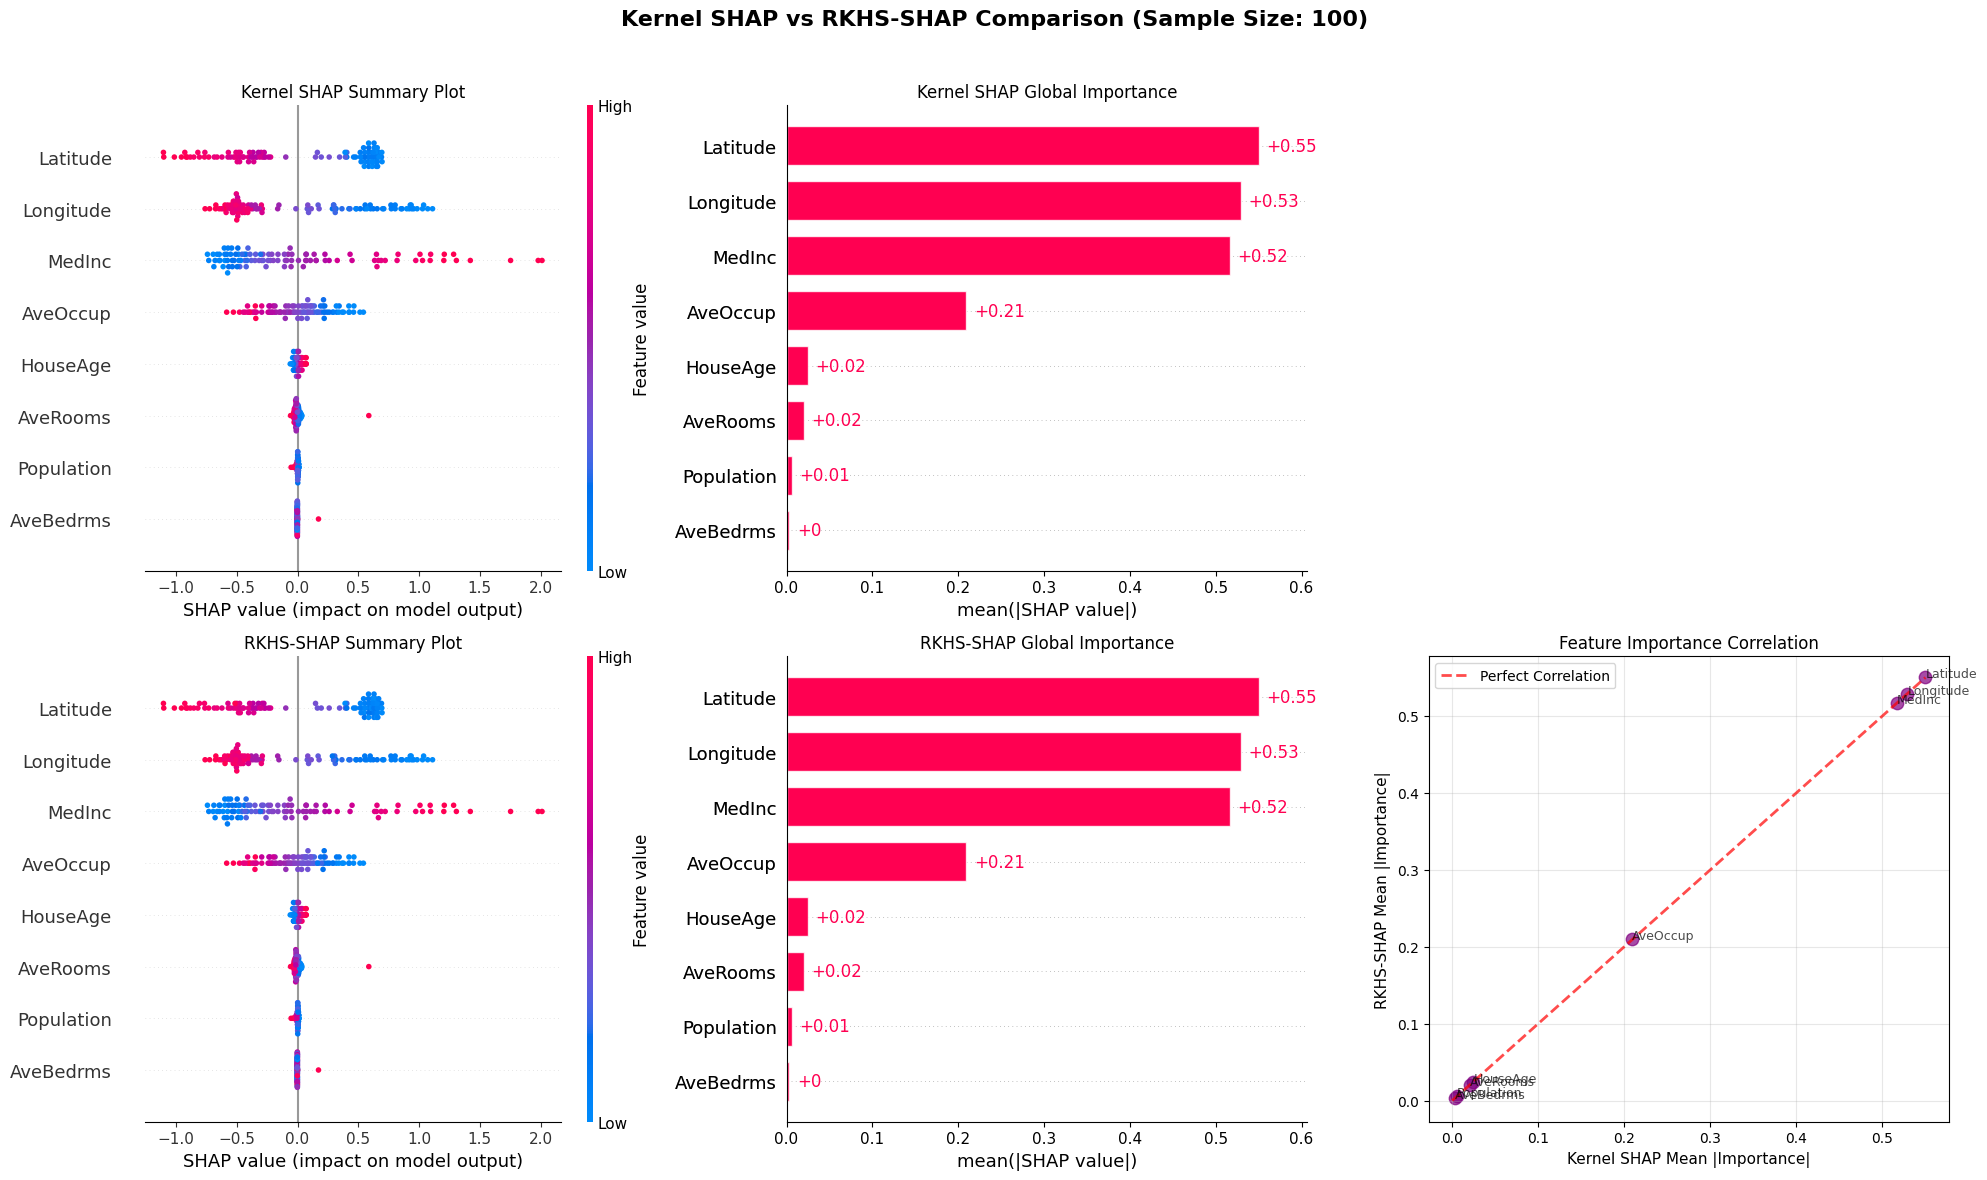

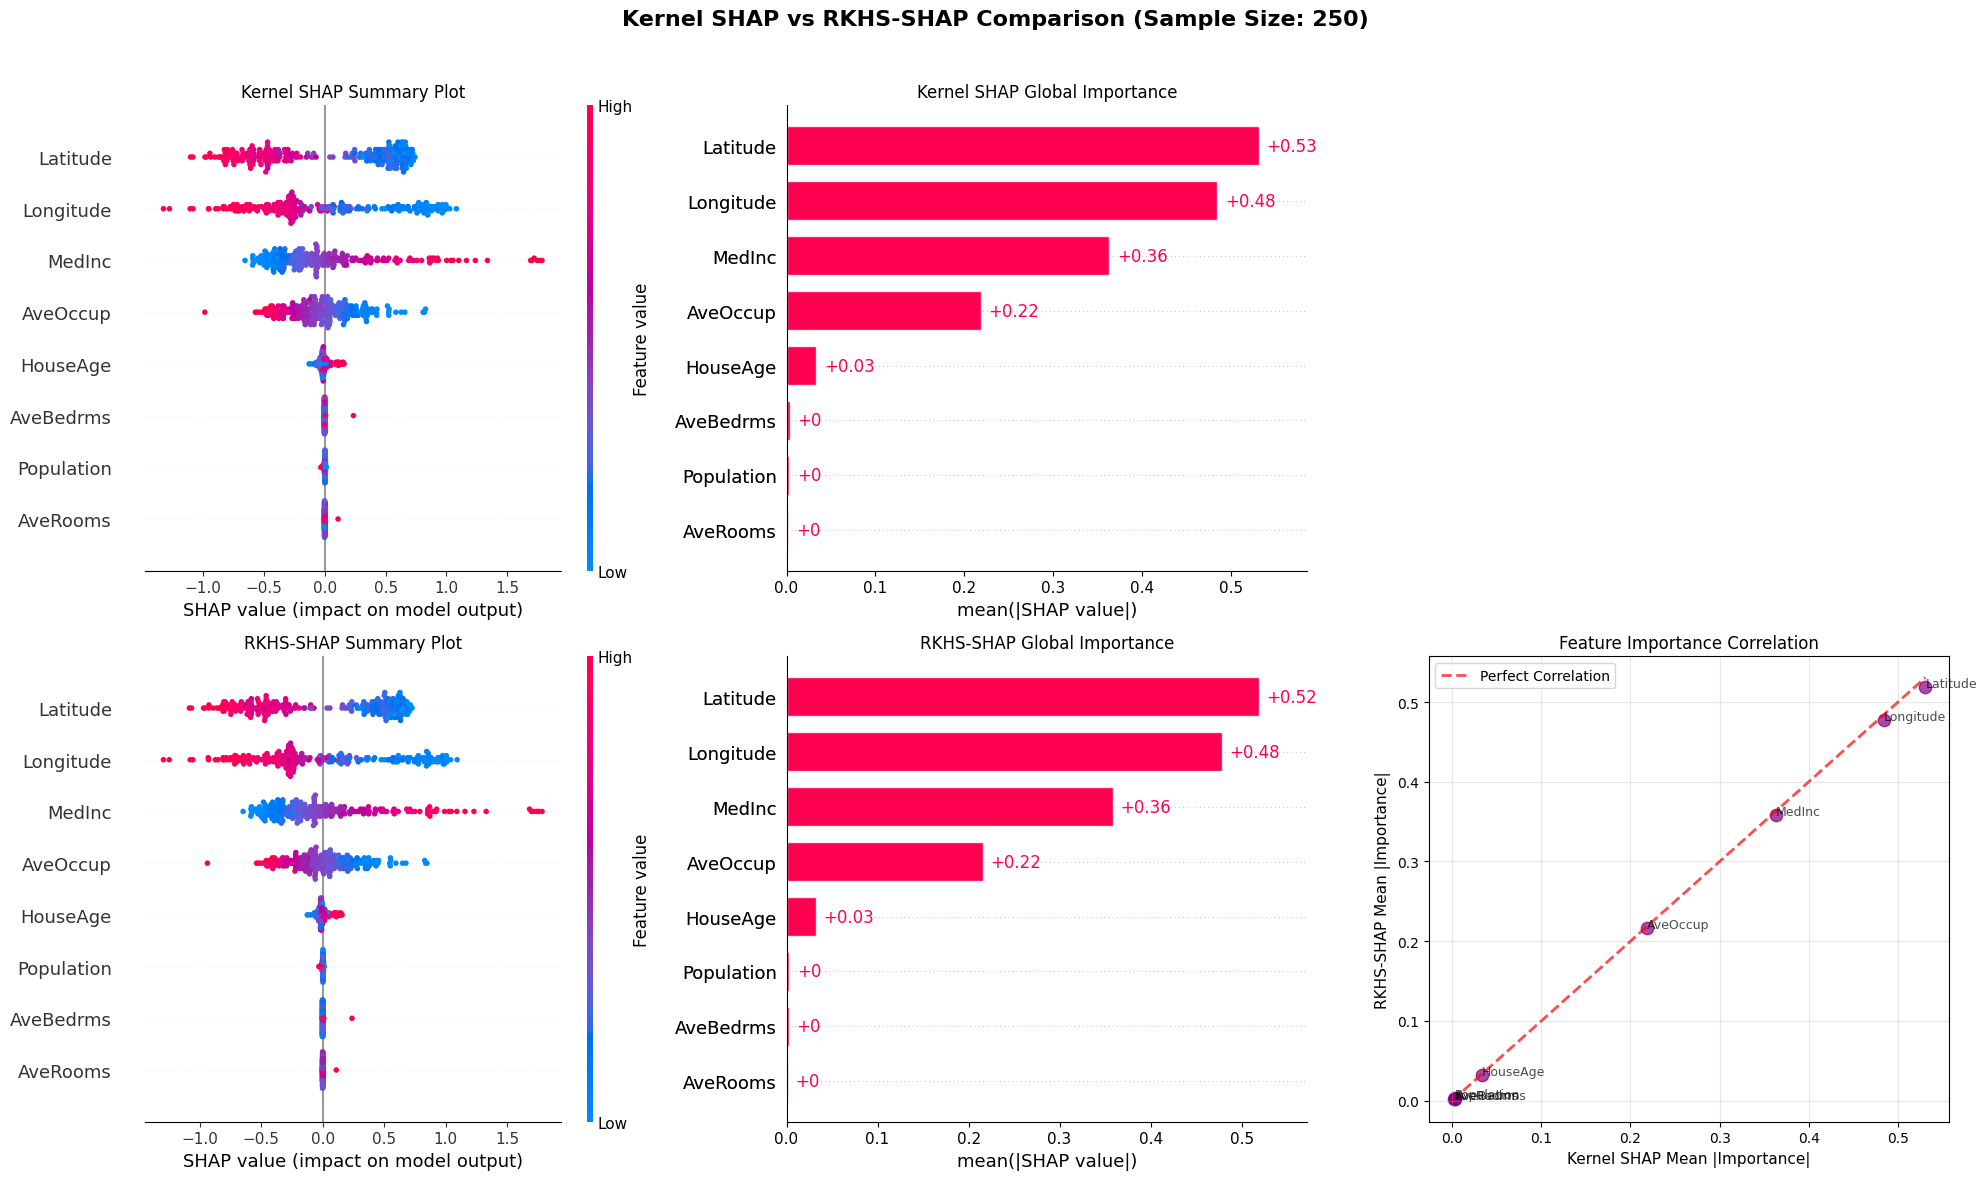

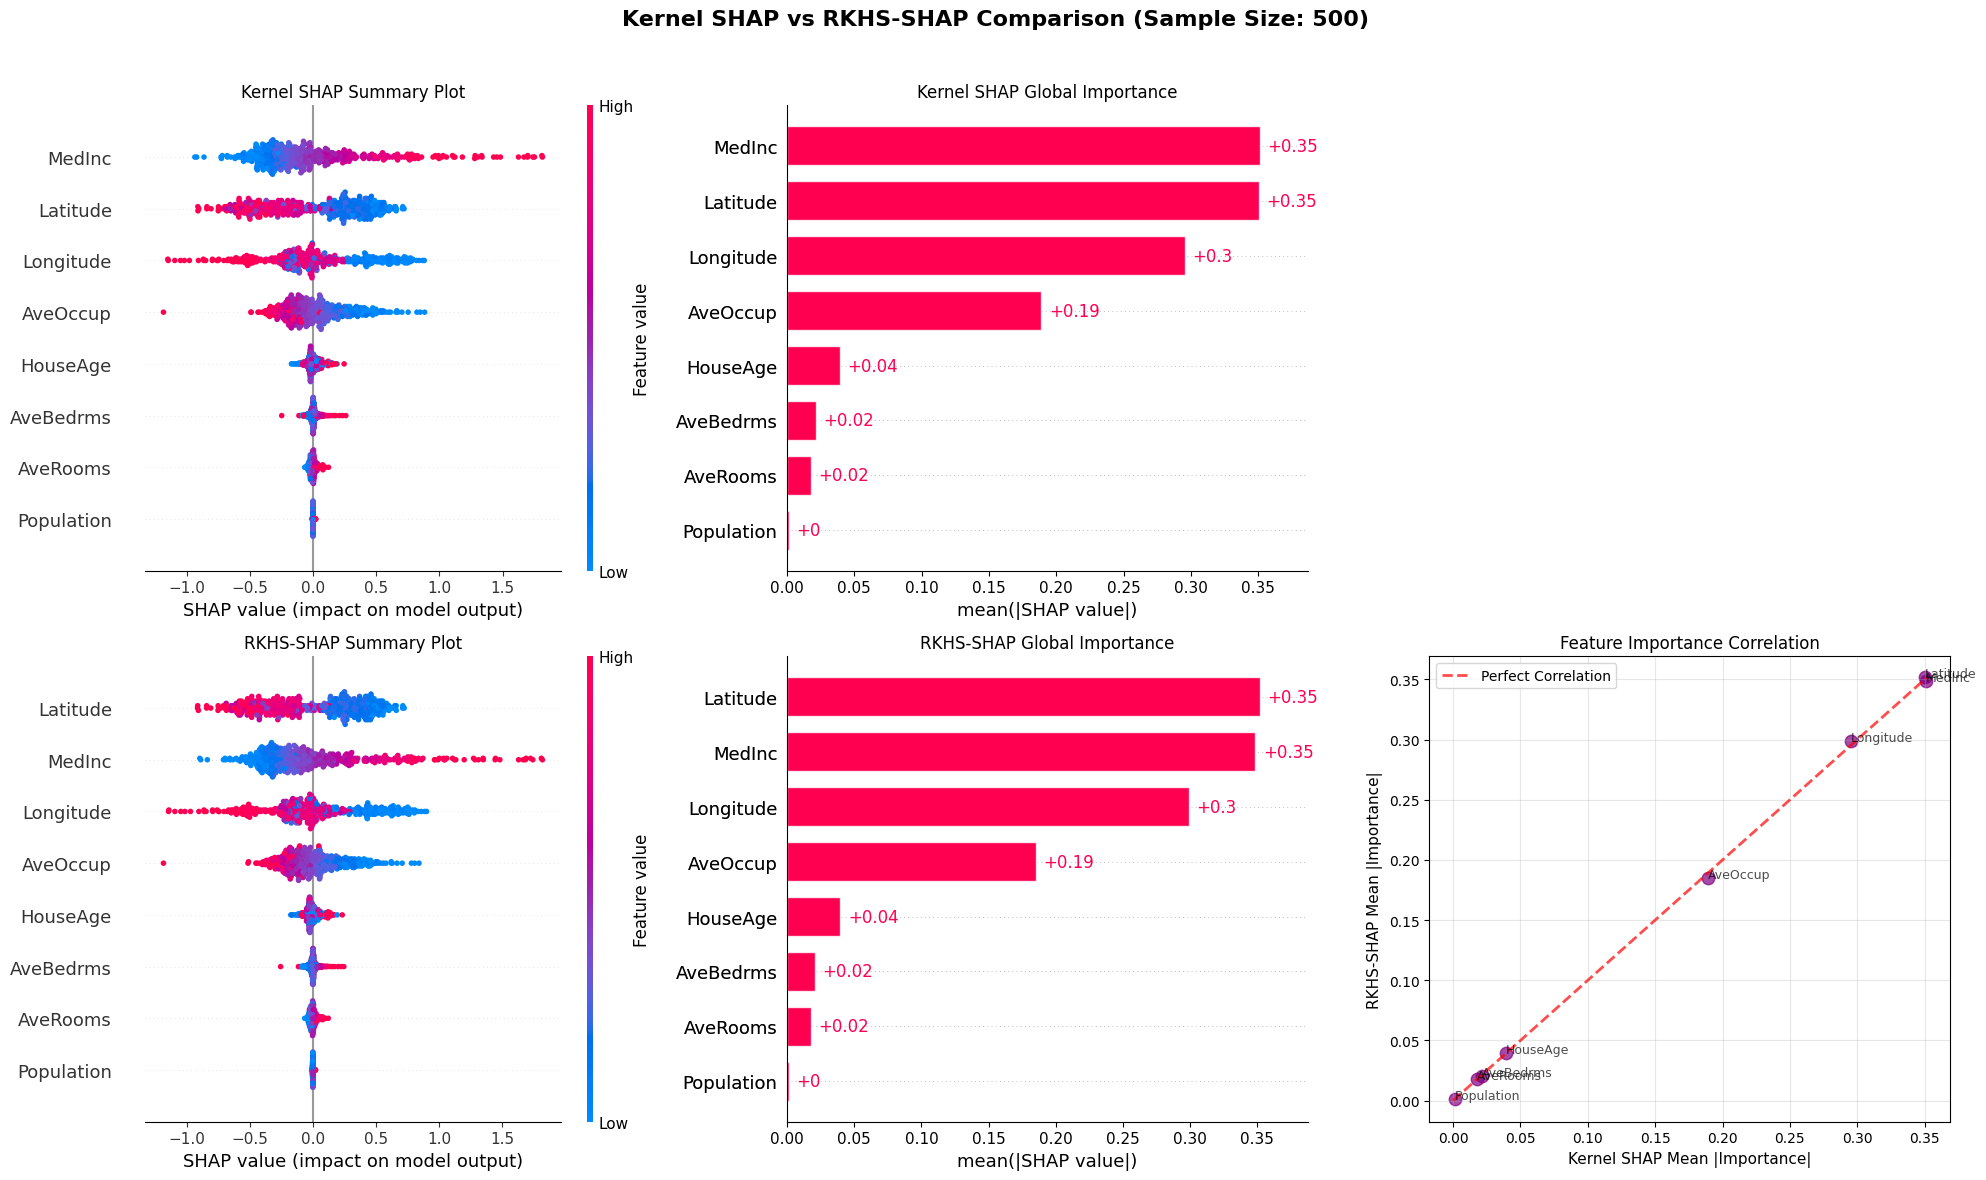

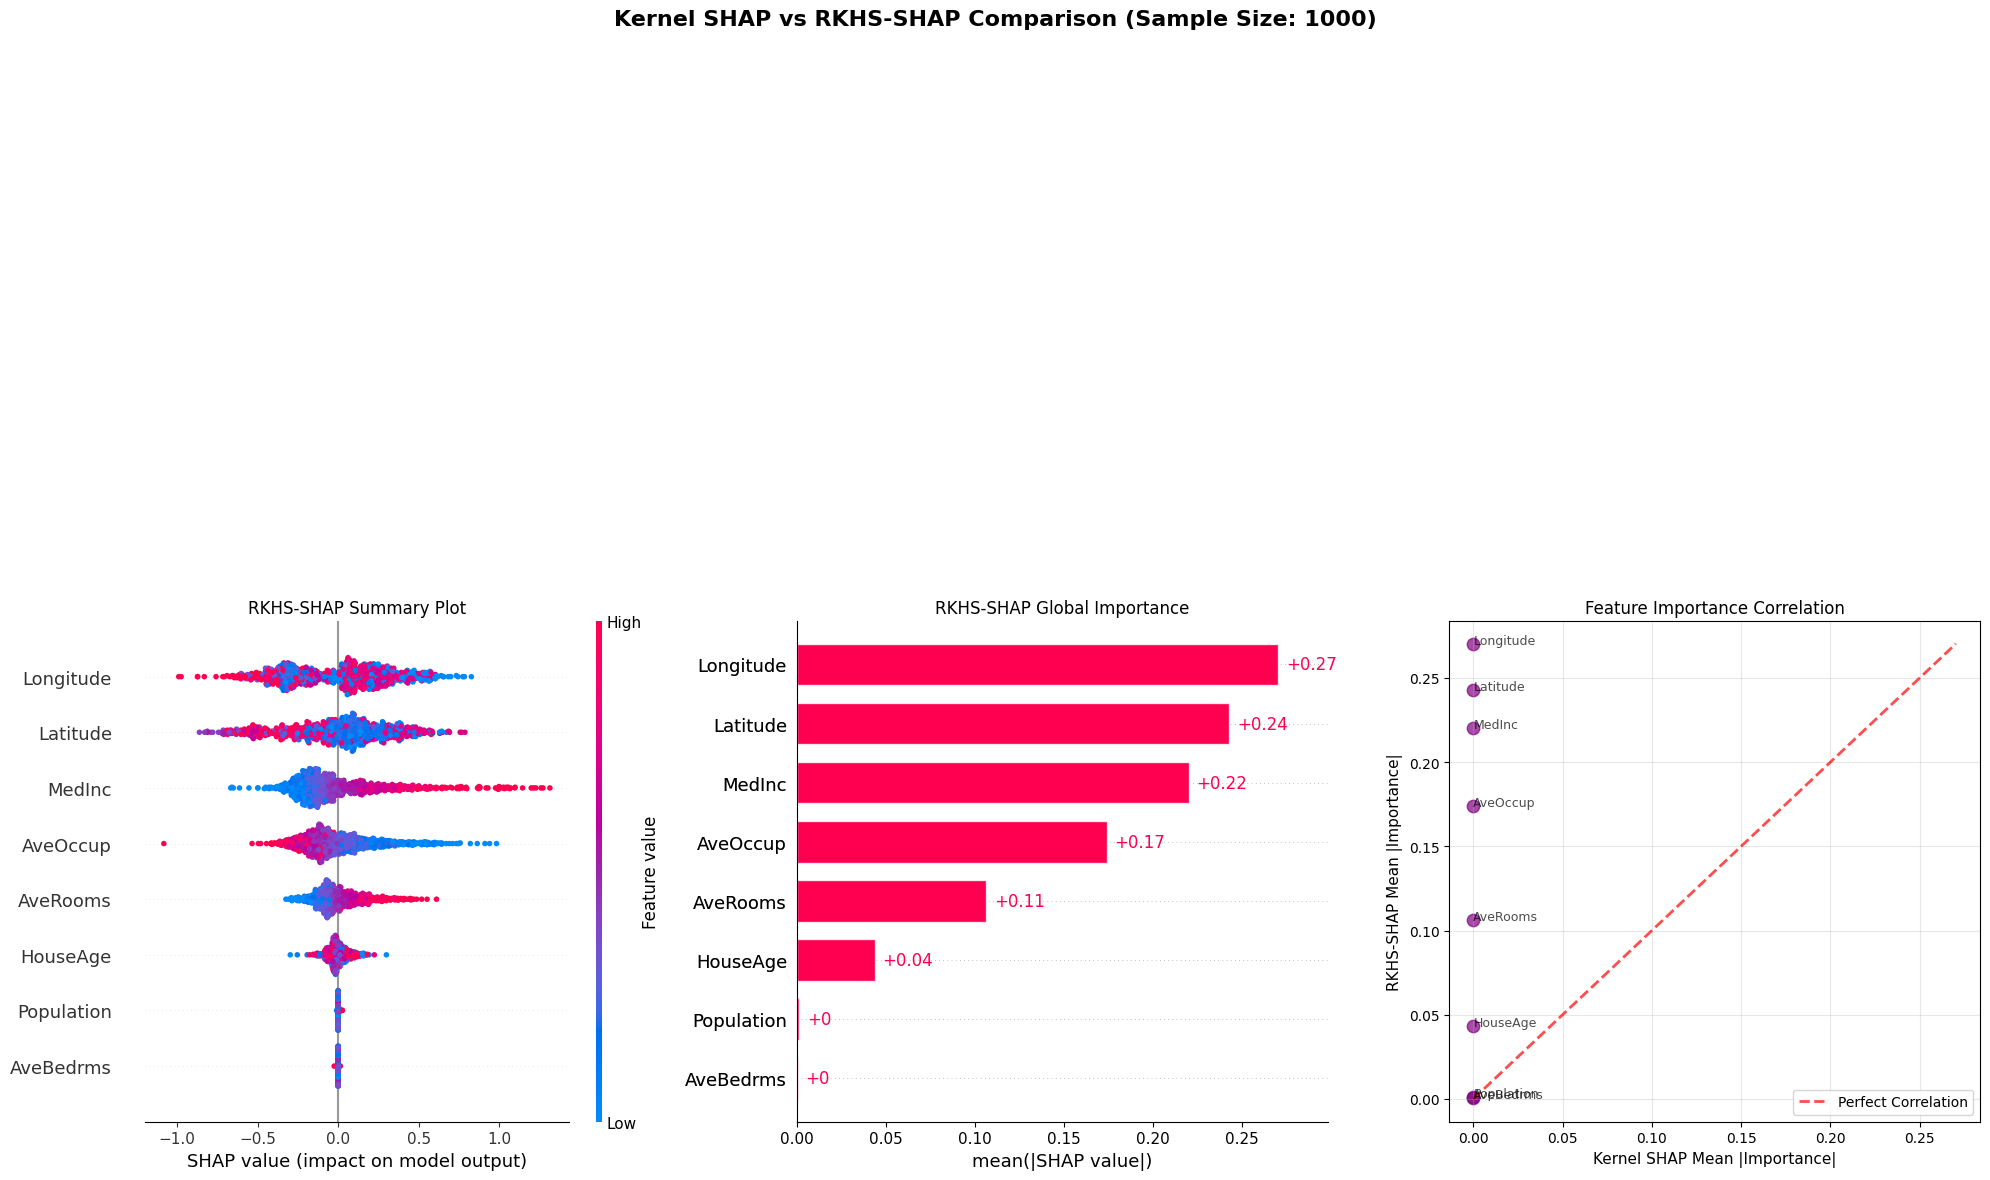

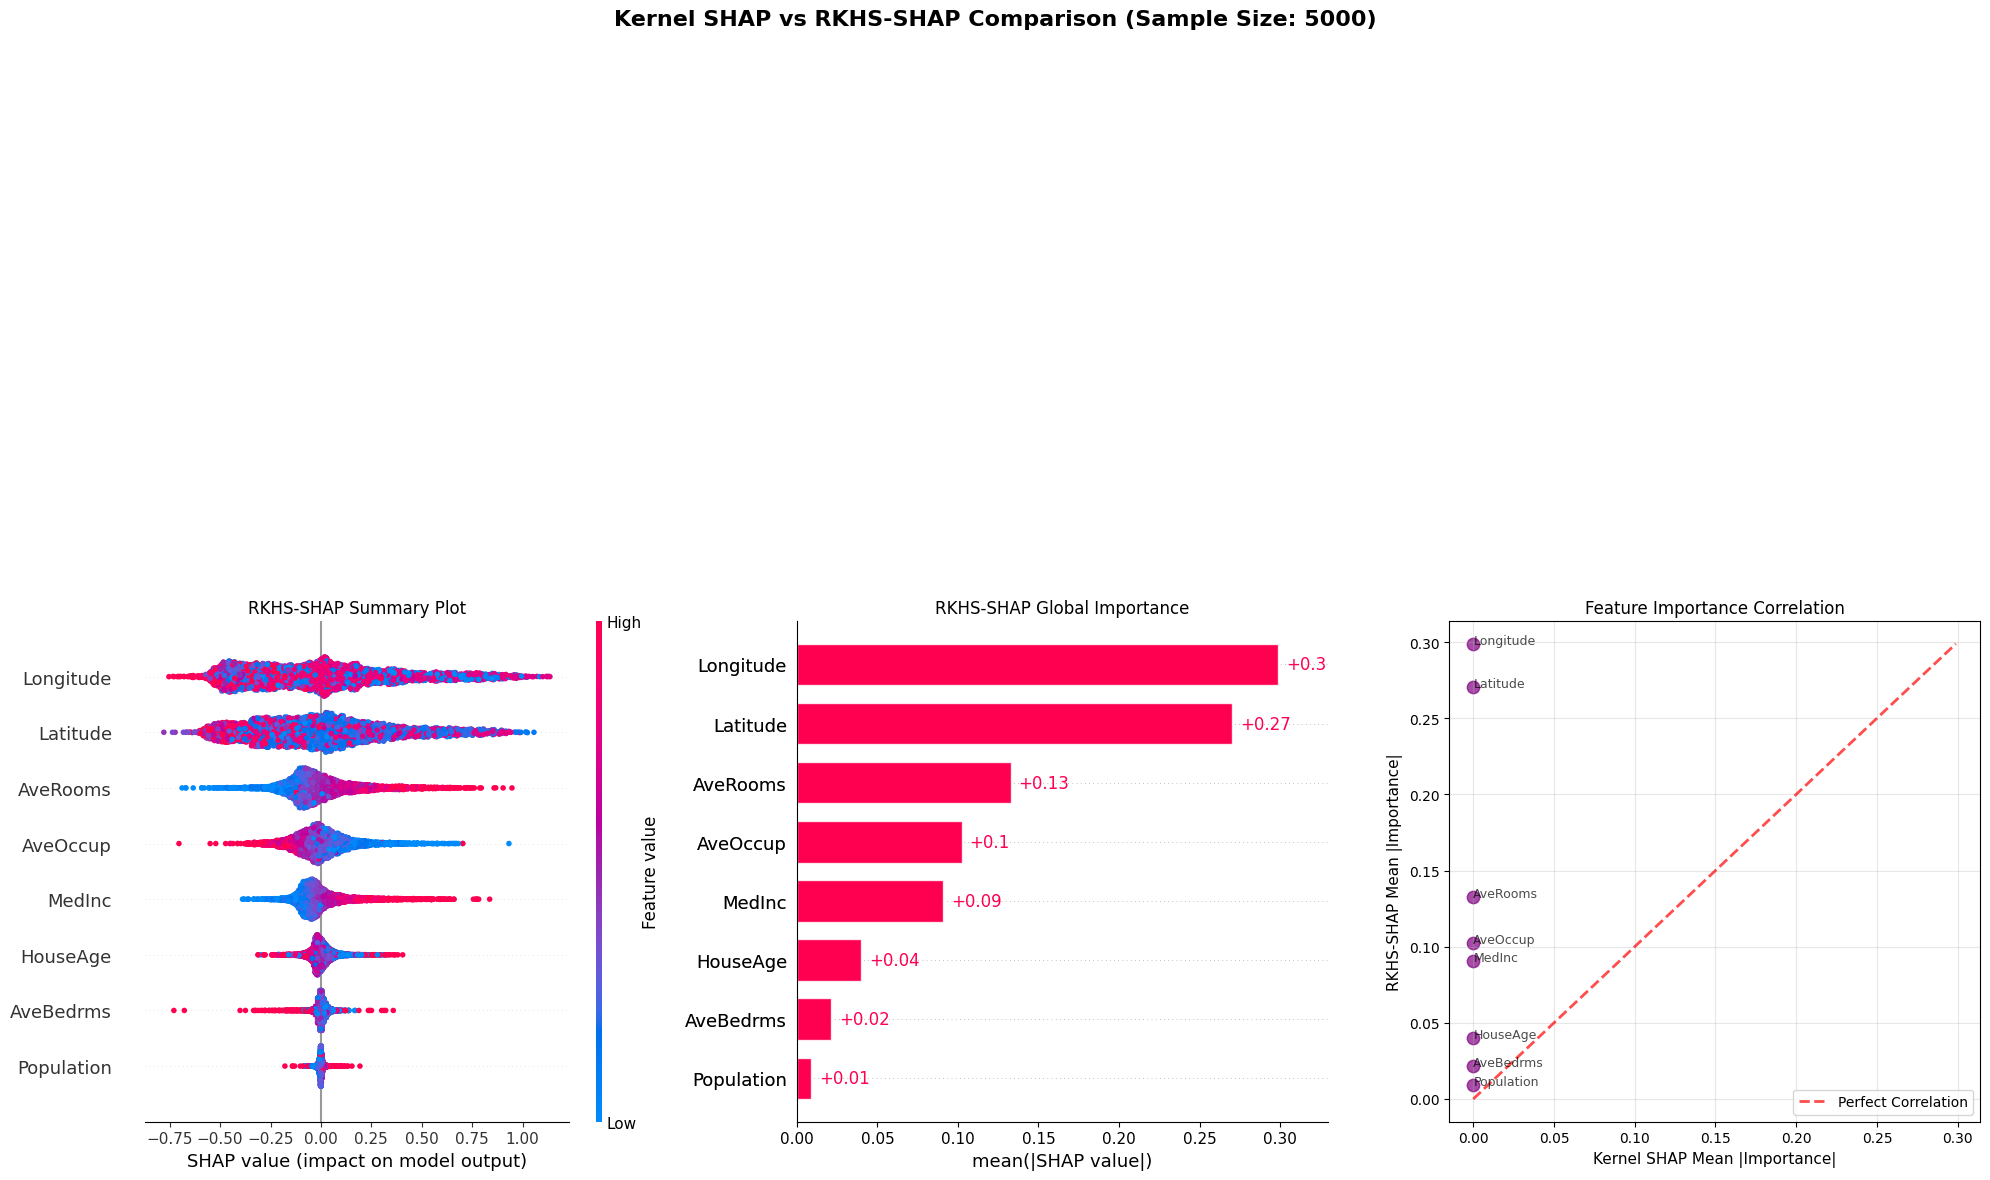

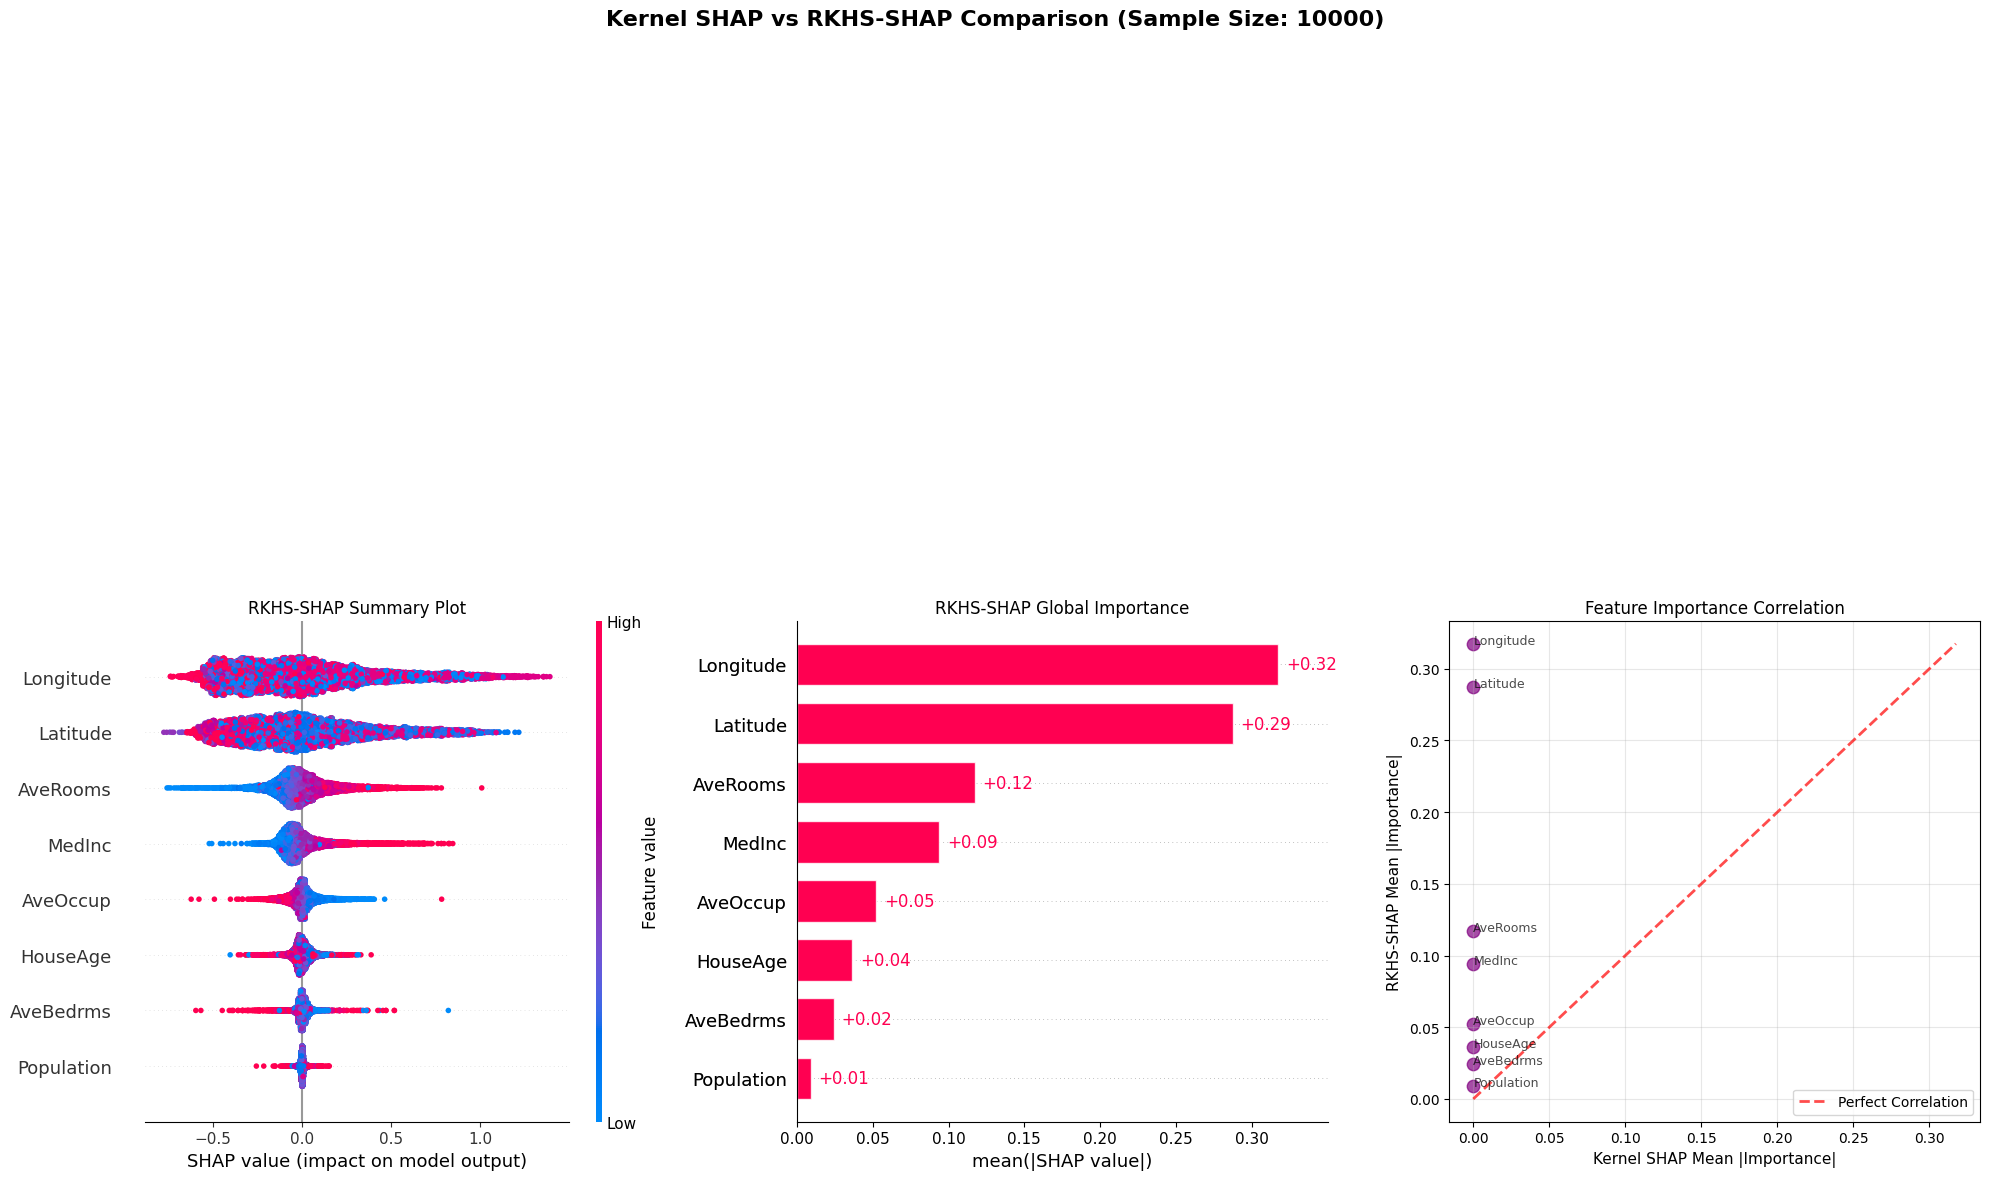

In [63]:
for i, sample_size in enumerate(SAMPLE_SIZES):
    kernel_explanation: shap.Explanation | None = all_kernel_explanations[i]
    rkhs_explanation: shap.Explanation = all_rkhs_explanations[i]
    model = all_models[i]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(
        f"Kernel SHAP vs RKHS-SHAP Comparison (Sample Size: {sample_size})",
        fontsize=16,
        fontweight="bold",
    )

    # Correlation plot between methods
    rkhs_mean_abs = np.mean(np.abs(rkhs_explanation.values), axis=0)
    kernel_mean_abs = np.zeros_like(rkhs_mean_abs)

    # Kernel SHAP plots
    if kernel_explanation is not None:
        kernel_mean_abs = np.mean(np.abs(kernel_explanation.values), axis=0)
        shap.plots.beeswarm(
            kernel_explanation, ax=axes[0, 0], plot_size=None, show=False
        )
        axes[0, 0].set_title("Kernel SHAP Summary Plot", fontsize=12)

        shap.plots.bar(kernel_explanation, ax=axes[0, 1], show=False)
        axes[0, 1].set_title("Kernel SHAP Global Importance", fontsize=12)

        axes[0, 2].set_visible(False)
    else:
        axes[0, 0].set_visible(False)
        axes[0, 1].set_visible(False)
        axes[0, 2].set_visible(False)

    shap.plots.beeswarm(rkhs_explanation, ax=axes[1, 0], plot_size=None, show=False)
    axes[1, 0].set_title("RKHS-SHAP Summary Plot", fontsize=12)
    shap.plots.bar(rkhs_explanation, ax=axes[1, 1], show=False)
    axes[1, 1].set_title("RKHS-SHAP Global Importance", fontsize=12)

    axes[1, 2].scatter(kernel_mean_abs, rkhs_mean_abs, alpha=0.7, s=80, color="purple")

    # Add feature labels
    for j, name in enumerate(feature_names):
        axes[1, 2].annotate(
            name, (kernel_mean_abs[j], rkhs_mean_abs[j]), fontsize=9, alpha=0.7
        )

    # Perfect correlation line
    max_val = max(kernel_mean_abs.max(), rkhs_mean_abs.max())
    axes[1, 2].plot(
        [0, max_val],
        [0, max_val],
        "r--",
        alpha=0.7,
        label="Perfect Correlation",
        linewidth=2,
    )

    axes[1, 2].set_xlabel("Kernel SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_ylabel("RKHS-SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_title("Feature Importance Correlation", fontsize=12)
    axes[1, 2].legend(fontsize=10)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()